# Stroke Prediction and EDA

### **Table of Contents**
* [<span style="color:#A690A4"> 0. Executive Summary](#exe_sum)
* [<span style="color:#A690A4"> 1. Introduction](#intro)
* [<span style="color:#A690A4"> 2. Collect, Wrangle & Explore Data](#process)
* [<span style="color:#A690A4"> 3. Predict Asking Price](#predict)
* [<span style="color:#A690A4"> 4. Conclusion](#conclusion)

# <span style="color:#5E6997">Executive Summary</span> <a class="anchor" id="exe_sum"></a>

# <span style="color:#5E6997">Introduction</span> <a class="anchor" id="intro"></a>

## General Approach

**Do Before Splitting:**
1. ✓ Address missing values.
2. ✓ Address outliers.

3. ✓ Irrelevant feature removal.

**Do After Splitting:**
1. ✓ One-Hot Encoding.
2. ✓ Imputation.
3. Feature engineering.
4. Feature selection.
5. Scaling.

Here are some recommended models and methodologies based on typical approaches for predictive modeling in healthcare.

### 1. Supervised Learning Models
The task is likely binary classification (predicting the presence or absence of stroke), so the following models are suitable:

#### Traditional Machine Learning Models
- **Logistic Regression**: For interpretability and simplicity. Effective if relationships between predictors and the target are linear.
- **Random Forest**: For handling non-linear relationships and feature importance analysis.
- **Gradient Boosting** (e.g., XGBoost, LightGBM, CatBoost): For high-performance predictions and handling imbalanced datasets.
- **Support Vector Machines (SVMs)**: Effective for small to medium datasets with a clear margin of separation.

#### Neural Networks
- **Multi-Layer Perceptrons (MLPs)**: If the dataset is large and relationships are complex.
- **Deep Learning Architecture**s: Useful for extensive feature engineering or large-scale data.

### 2. Handling Imbalanced Data
Stroke datasets are often imbalanced (stroke events are relatively rare). To address this:

- Use resampling techniques (e.g., SMOTE for oversampling, undersampling).
- Leverage class weights in algorithms like logistic regression or gradient boosting.

### 3. Exploratory and Feature Selection Techniques
Before modeling, consider:

- Feature engineering and selection: Use methods like mutual information, recursive feature elimination (RFE), or Lasso regression to identify important predictors.
- PCA (Principal Component Analysis): If dimensionality reduction is necessary.

### 4. Evaluation Metrics
Since stroke prediction is a high-stakes task, consider:

- **ROC-AUC**: For overall model performance.
- **Precision, Recall, and F1-Score**: To balance sensitivity and specificity.
- **Confusion Matrix**: For detailed error analysis.

## The Features

The dataset contains 12 columns with a mix of numerical and categorical data, and it has some missing values in the bmi column. Here's a summary of key features:

### Key Features:
**Demographics**:
1. gender (categorical): Male, Female, or possibly others.
2. age (numerical): Continuous; spans from 0.08 to 82.

**Health Metrics:**
1. hypertension (binary): 0 (no), 1 (yes).
2. heart_disease (binary): 0 (no), 1 (yes).
3. avg_glucose_level (numerical): Continuous; ranges from 55.12 to 271.74.
4. bmi (numerical): Continuous; has missing values.

**Lifestyle and Social Factors:**
1. ever_married (categorical): Yes or No.
2. work_type (categorical): Includes the categories "children", "Govt_jov", "Never_worked", "Private" and "Self-employed".
3. Residence_type (categorical): Urban or Rural.
4. smoking_status (categorical): Includes "formerly smoked," "never smoked," "smokes," and possibly unknown.

**Target Variable:**
- stroke (binary): 0 (no stroke) or 1 (stroke).

# <span style="color:#5E6997">Collect, Wrangle, and Explore Data</span> <a class="anchor" id="process"></a>

In [1]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
# Drop the 'id' column.
df.drop(columns=['id'], inplace=True)

In [4]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## Number of Outliers

In [5]:
from scipy.stats import zscore

# Calculate Z-scores for numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
z_scores = np.abs(df[numerical_columns].apply(zscore))

# Identify outliers
outliers = z_scores > 3
print("Outliers detected in each numerical column:")
print(outliers.sum())


Outliers detected in each numerical column:
age                    0
hypertension         498
heart_disease        276
avg_glucose_level     49
bmi                    0
stroke               249
dtype: int64


Outliers will be left alone for now since some of the models that will be used will not be impacted by outlers.

## Define the Categorical Variables and the Range of Unique Values

In [6]:
categorical_columns = df[['gender','ever_married', 'work_type', 'Residence_type',
       'smoking_status', 'hypertension', 'heart_disease']]

In [7]:
categorical_columns.head()

,gender,ever_married,work_type,Residence_type,smoking_status,hypertension,heart_disease
0,Male,Yes,Private,Urban,formerly smoked,0,1
1,Female,Yes,Self-employed,Rural,never smoked,0,0
2,Male,Yes,Private,Rural,never smoked,0,1
3,Female,Yes,Private,Urban,smokes,0,0
4,Female,Yes,Self-employed,Rural,never smoked,1,0


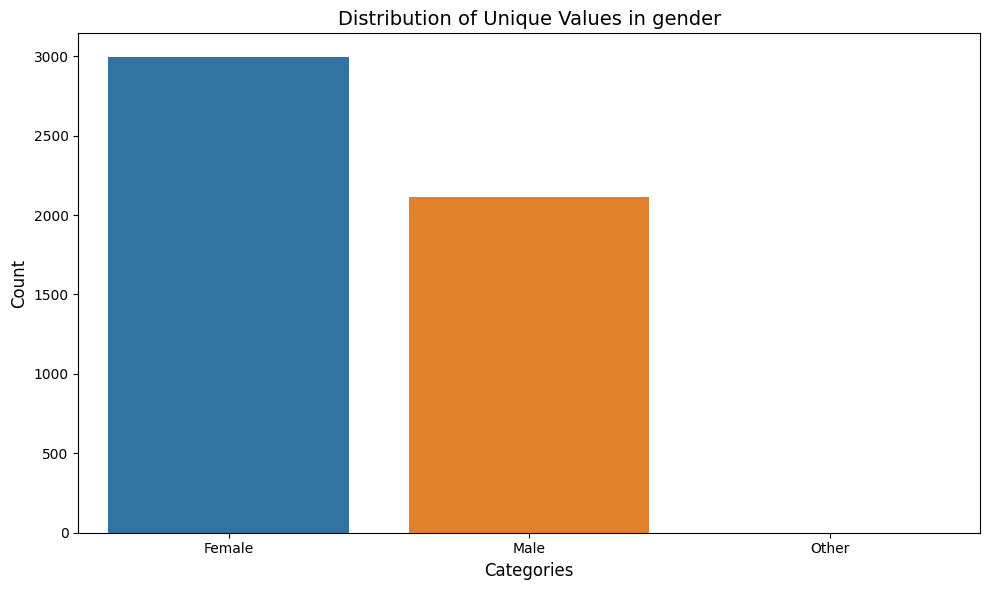

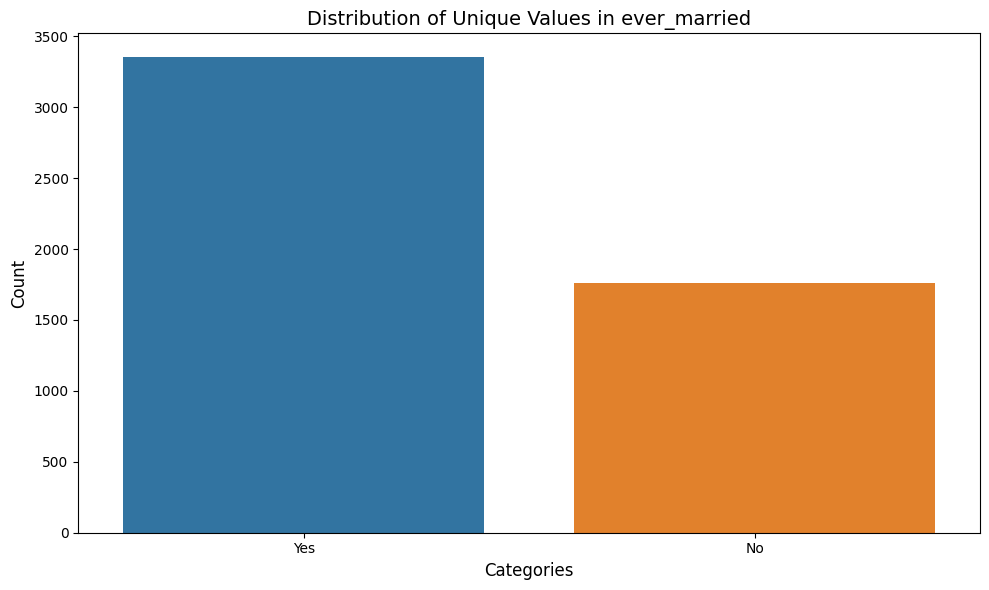

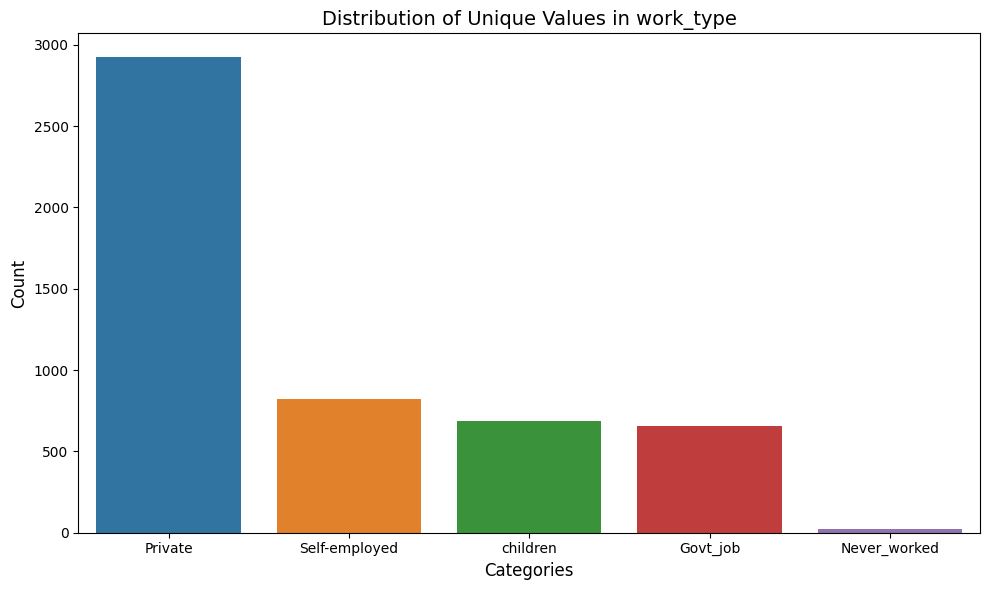

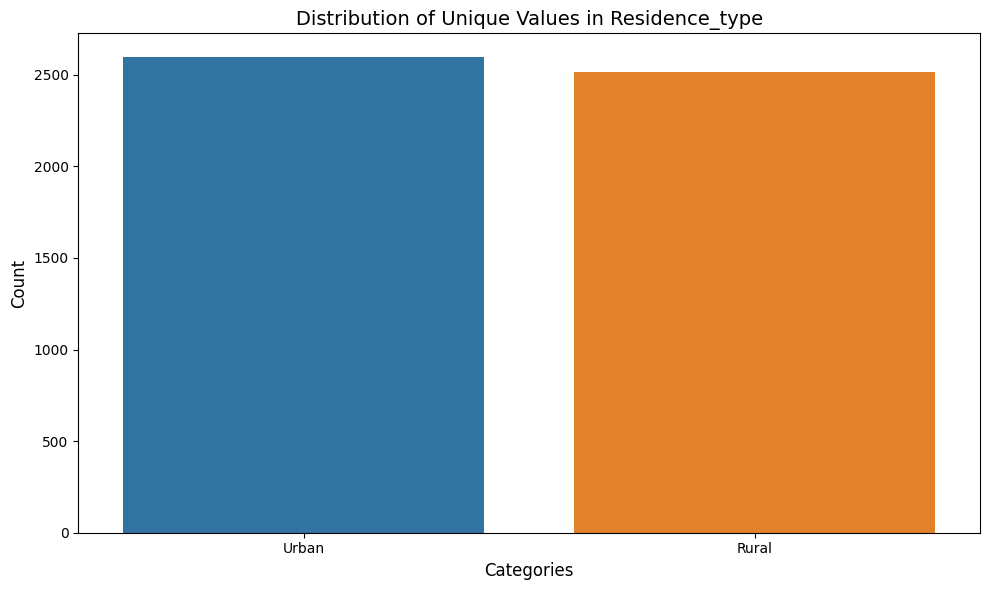

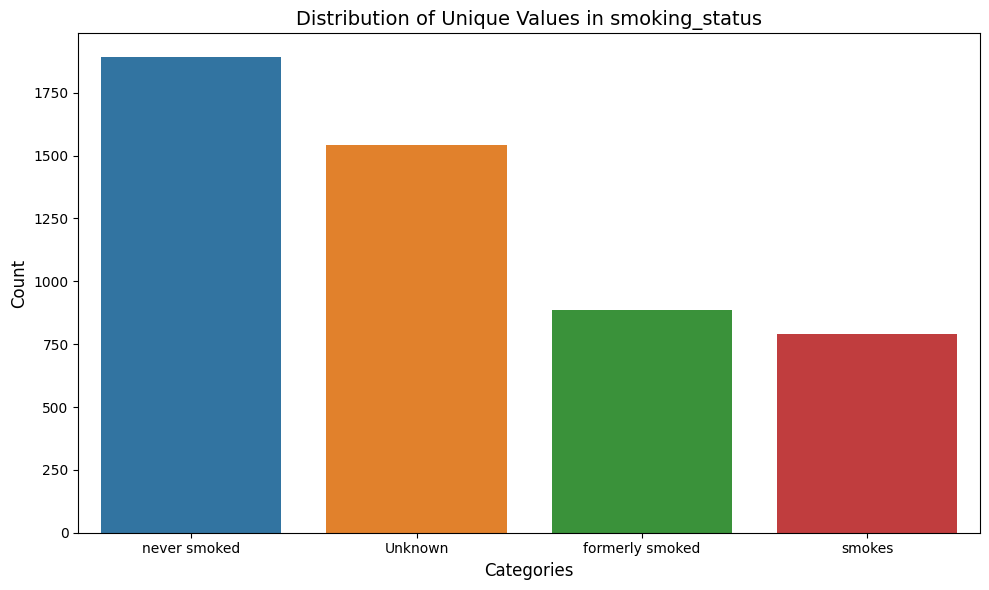

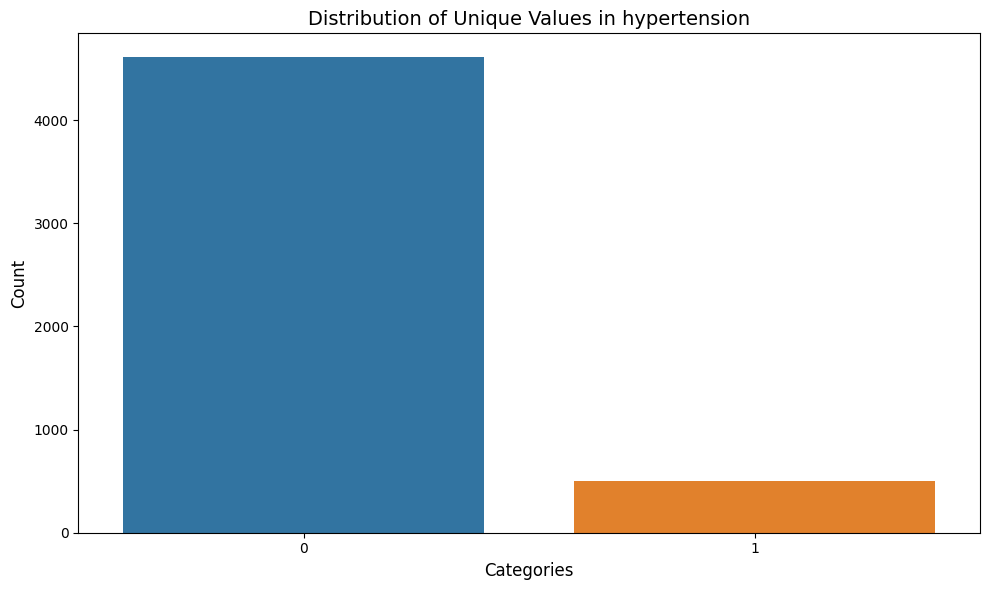

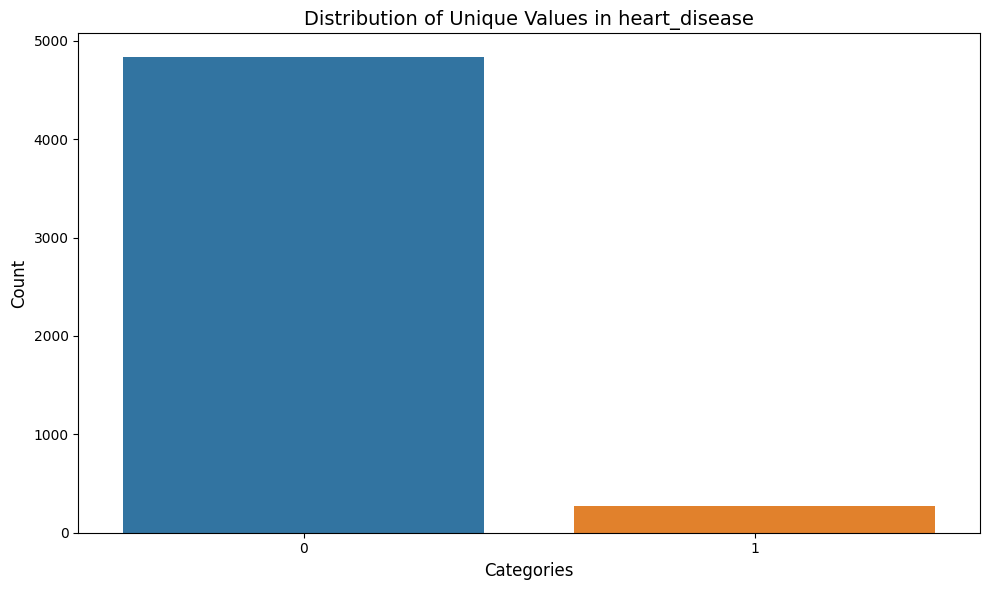

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of unique values for each categorical variable
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Distribution of Unique Values in {column}', fontsize=14)
    plt.xlabel('Categories', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.tight_layout()
    plt.show()

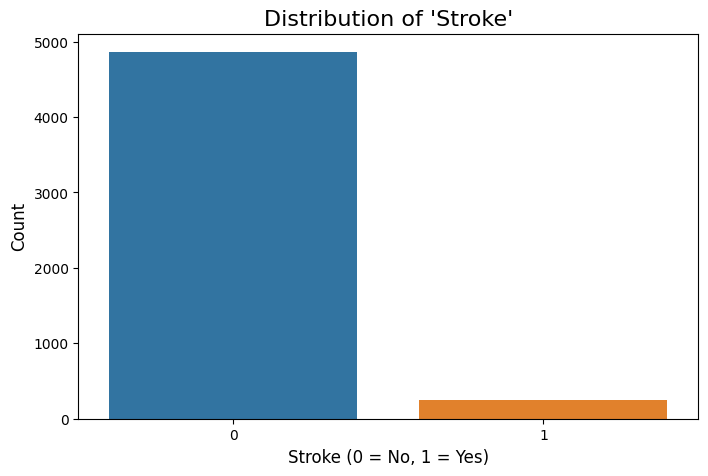

In [9]:
# Plot the distribution of 'stroke'
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='stroke')
plt.title("Distribution of 'Stroke'", fontsize=16)
plt.xlabel("Stroke (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


## Numerical Feature Distribution

In [10]:
numerical_columns = df.drop(columns=categorical_columns.columns.tolist() + ['stroke'])

In [11]:
numerical_columns

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,61.0,202.21,NaN
2,80.0,105.92,32.5
3,49.0,171.23,34.4
4,79.0,174.12,24.0
...,...,...,...
5105,80.0,83.75,NaN
5106,81.0,125.20,40.0
5107,35.0,82.99,30.6
5108,51.0,166.29,25.6


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


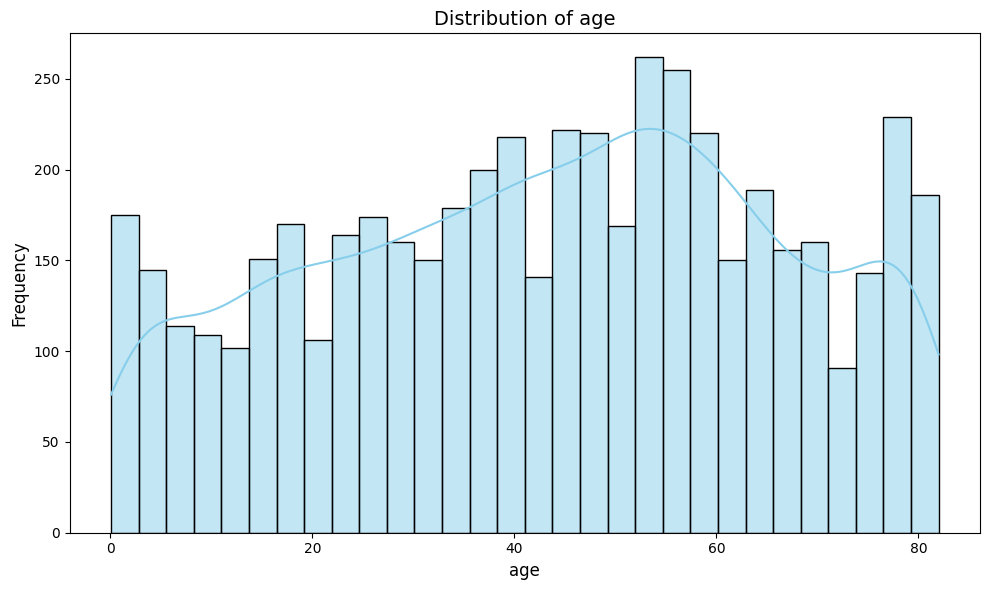

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


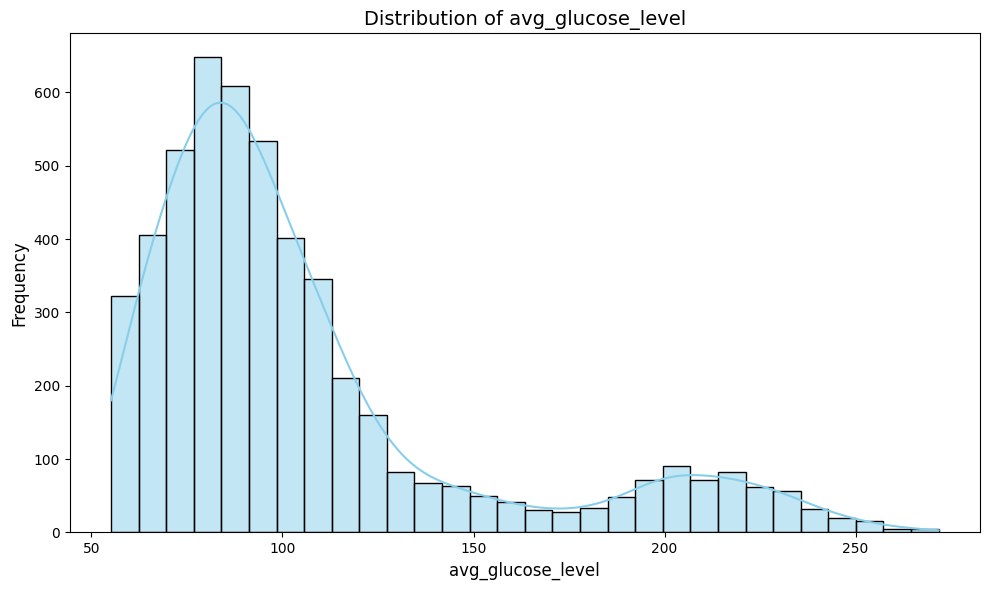

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


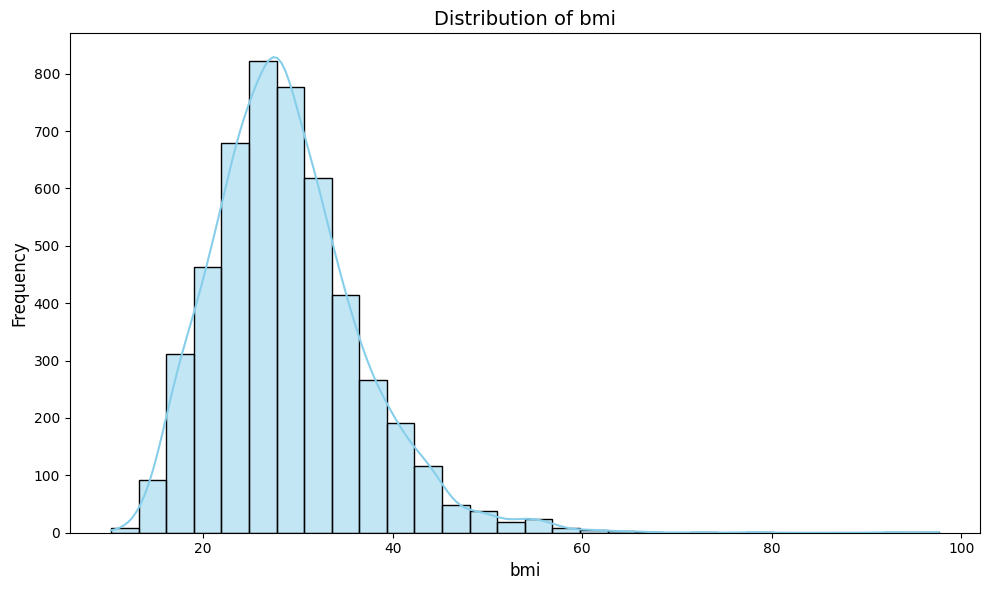

In [12]:
# Plot the distribution of each numerical variable
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()


In [13]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


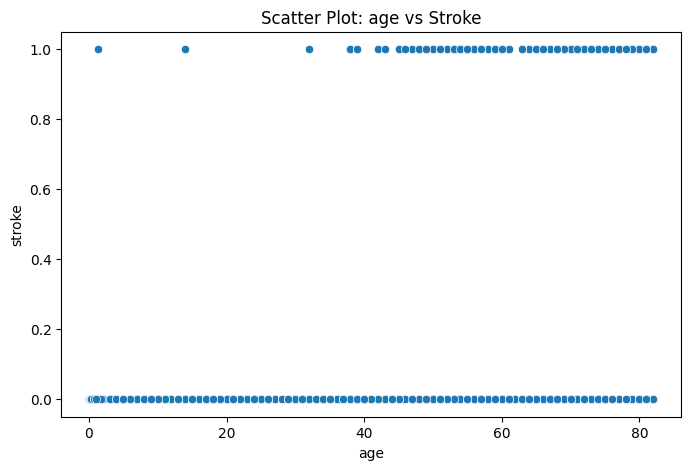

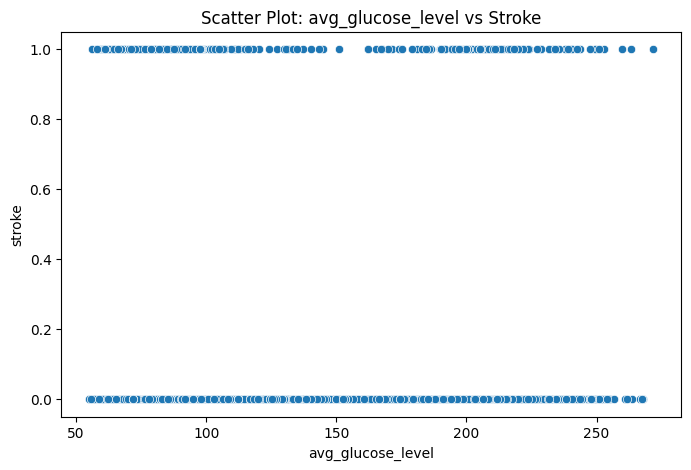

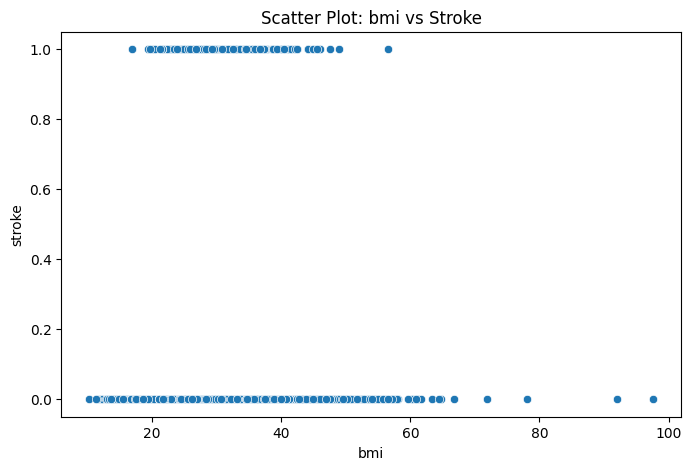

In [14]:
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=column, y='stroke')
    plt.title(f"Scatter Plot: {column} vs Stroke")
    plt.show()

## Train/Test Split

Define 'X' and 'y'.

In [15]:
X = df.drop(columns=['stroke'])  
y = df['stroke']  

Split the dataframe.

In [16]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

## Impute missing values of 'bmi' in the Test and Train data.

In [17]:
# Group by relevant features and calculate median/mean for BMI
grouped_median = X_train.groupby(['gender', 'smoking_status'])['bmi'].median()

# Function to impute missing BMI values based on grouped median
def impute_bmi(data, grouped_median):
    for (gender, smoking_status), median_value in grouped_median.items():
        mask = (data['gender'] == gender) & (data['smoking_status'] == smoking_status) & (data['bmi'].isnull())
        data.loc[mask, 'bmi'] = median_value
    return data

# Impute BMI in training data
X_train = impute_bmi(X_train, grouped_median)

# Impute BMI in test data using training grouped median
X_test = impute_bmi(X_test, grouped_median)

## One-Hot Encoding

In [18]:
from sklearn.preprocessing import OneHotEncoder

# Features to one-hot encode
one_hot_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Example: Providing all possible categories manually
all_categories = [
    ['Male', 'Female', 'Other'],  # gender
    ['Yes', 'No'],               # ever_married
    ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],  # work_type
    ['Urban', 'Rural'],          # Residence_type
    ['formerly smoked', 'never smoked', 'smokes', 'Unknown']  # smoking_status
]

encoder = OneHotEncoder(categories=all_categories, sparse_output=False, drop='first')

# Fit and transform the training data
X_train_encoded = encoder.fit_transform(X_train[one_hot_features])

# Transform the test data
X_test_encoded = encoder.transform(X_test[one_hot_features])

# Convert encoded arrays back to DataFrames
encoded_feature_names = encoder.get_feature_names_out(one_hot_features)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# Drop original categorical columns and add the encoded columns
X_train = X_train.drop(columns=one_hot_features).join(X_train_encoded_df)
X_test = X_test.drop(columns=one_hot_features).join(X_test_encoded_df)

In [19]:
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Other,ever_married_No,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Rural,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
943,75.0,0,0,86.40,42.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
821,70.0,1,0,88.66,36.7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4675,8.0,0,0,63.43,21.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3737,73.0,0,0,98.69,27.6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2067,40.0,0,0,212.97,49.8,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Feature Engineering

- Feature engineering and selection: Use methods like mutual information, recursive feature elimination (RFE), or Lasso regression to identify important predictors.
- PCA (Principal Component Analysis): If dimensionality reduction is necessary.

In [20]:
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information on the training data
mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto')

# Create a DataFrame for better visualization
mi_scores_df = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
print(mi_scores_df)


age                            0.038284
bmi                            0.012718
ever_married_No                0.010549
heart_disease                  0.007785
smoking_status_Unknown         0.006629
smoking_status_never smoked    0.004875
avg_glucose_level              0.003658
hypertension                   0.003205
work_type_Never_worked         0.002333
work_type_children             0.002061
work_type_Govt_job             0.001926
gender_Female                  0.000957
gender_Other                   0.000000
work_type_Self-employed        0.000000
Residence_type_Rural           0.000000
smoking_status_smokes          0.000000
dtype: float64


In [21]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(random_state=0)

# Apply RFE to the training set
rfe = RFE(estimator=model, n_features_to_select=5)  # Select the top 5 features
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Transform the test set using the same RFE object
X_test_rfe = rfe.transform(X_test)

# Get the selected feature names
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['age', 'heart_disease', 'avg_glucose_level', 'bmi',
       'Residence_type_Rural'],
      dtype='object')


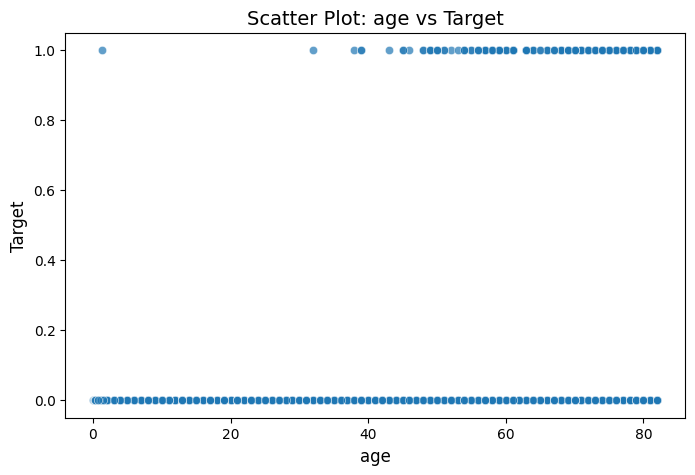

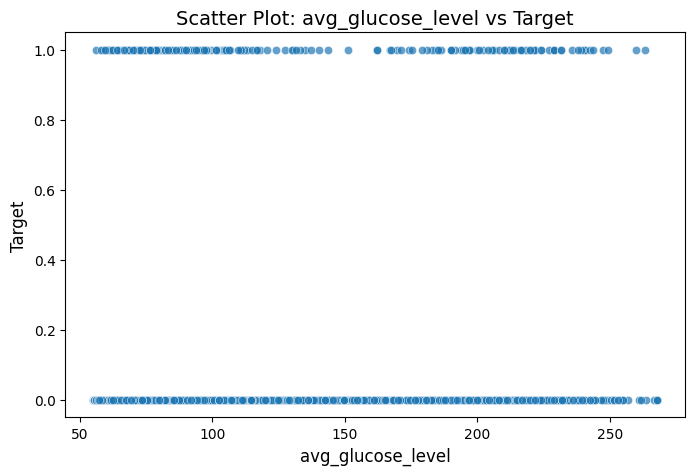

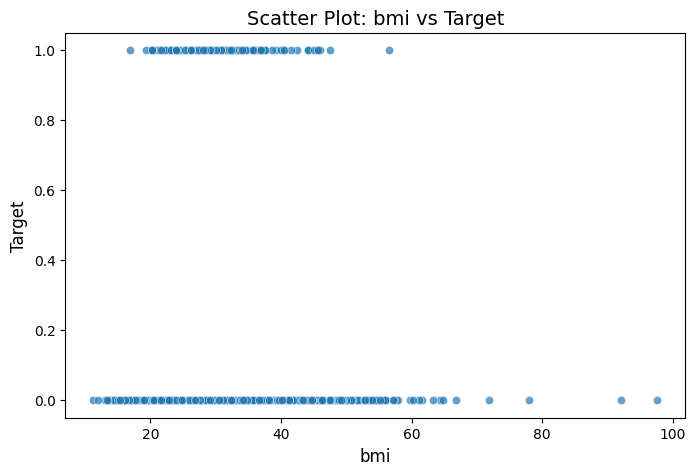

In [22]:
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=X_train[column], y=y_train, alpha=0.7)
    plt.title(f"Scatter Plot: {column} vs Target", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Target', fontsize=12)
    plt.show()

In [23]:
# sns.pairplot(pd.concat([X_train, y_train], axis=1), diag_kind='kde')
# plt.suptitle("Pair Plot of Features and Target", y=1.02, fontsize=16)
# plt.show()

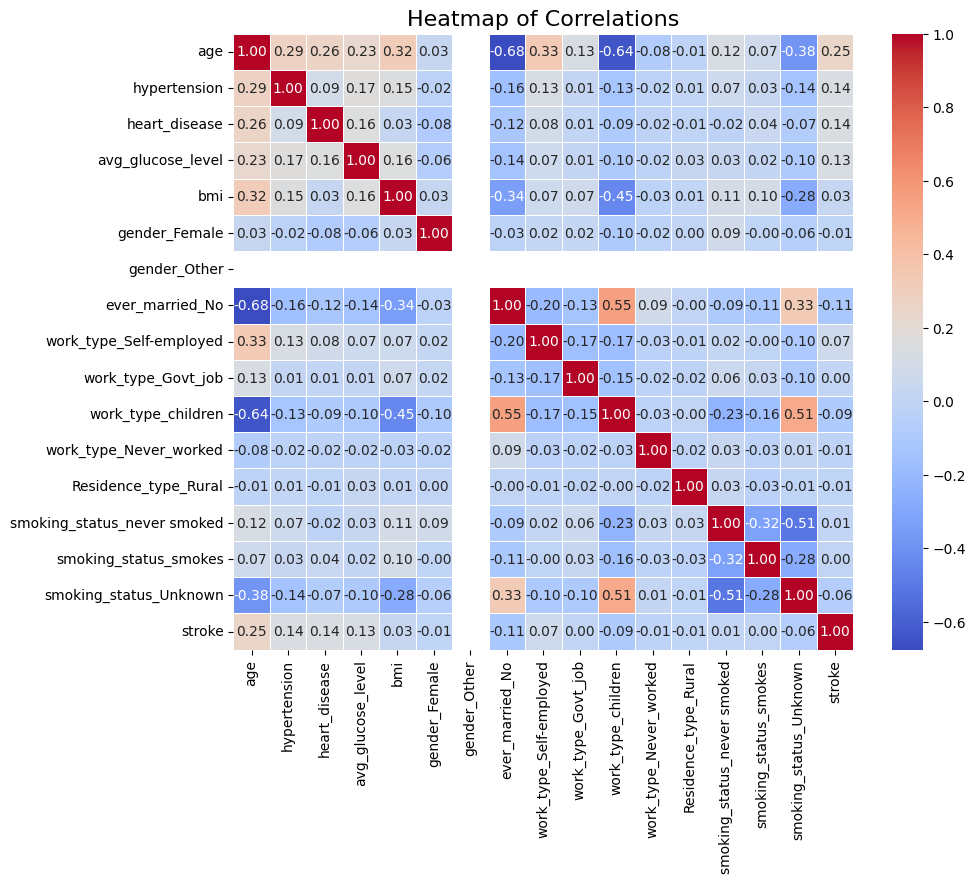

In [24]:
# Correlation matrix
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Correlations", fontsize=16)
plt.show()

# <span style="color:#5E6997">Predict Strokes</span> <a class="anchor" id="predict"></a>

## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the logistic regression model
# Train logistic regression with increased iterations 
logreg = LogisticRegression(
    random_state=0, 
    max_iter=1000, 
    solver='lbfgs'  # You can try 'saga' or 'liblinear' if issues persist
)
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)

Accuracy: 0.95
Confusion Matrix:
[[972   0]
 [ 49   1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022



- **Random Forest**: For handling non-linear relationships and feature importance analysis.
- **Gradient Boosting** (e.g., XGBoost, LightGBM, CatBoost): For high-performance predictions and handling imbalanced datasets.
- **Support Vector Machines (SVMs)**: Effective for small to medium datasets with a clear margin of separation.

## Random Forest Model

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train a base Random Forest model
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')  # Handle class imbalance
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)

Accuracy: 0.95
Confusion Matrix:
[[971   1]
 [ 50   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



## Gradient Boosting Model

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the Gradient Boosting model
gbm = GradientBoostingClassifier(random_state=0)
gbm.fit(X_train, y_train)

# Make predictions
y_pred = gbm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)

Accuracy: 0.95
Confusion Matrix:
[[970   2]
 [ 50   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



## Support Vector Machines (SVM) Model

In [28]:
from sklearn.svm import SVC

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=0, class_weight='balanced')
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)

Accuracy: 0.73
Confusion Matrix:
[[715 257]
 [ 15  35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       972
           1       0.12      0.70      0.20        50

    accuracy                           0.73      1022
   macro avg       0.55      0.72      0.52      1022
weighted avg       0.94      0.73      0.81      1022



# <span style="color:#5E6997">Conclusion</span> <a class="anchor" id="conclusion"></a>